# Financial Fraud Analysis

In [12]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, roc_curve, auc,roc_auc_score
import xgboost as xgb
import warnings as warning
warning.filterwarnings("ignore")

## Import Data and EDA

In [29]:
df_eda=pd.read_csv(r"C:\Postgre_dataset\Financial Fraud Dataset\synthetic_fraud_dataset.csv")
df_eda.head(5)

,transaction_id,user_id,amount,transaction_type,merchant_category,country,hour,device_risk_score,ip_risk_score,is_fraud
0,9608,363,4922.587542,ATM,Travel,TR,12,0.992347,0.947908,1
1,456,692,48.018303,QR,Food,US,21,0.168571,0.224057,0
2,4747,587,136.881960,Online,Travel,TR,14,0.296127,0.125058,0
3,6934,445,80.534719,POS,Clothing,TR,23,0.124801,0.159243,0
4,1646,729,120.041158,Online,Grocery,FR,16,0.098129,0.027542,0


In [30]:
df_eda['amount']=df_eda['amount'].astype(float).round(2)
df_eda['device_risk_score']=df_eda['device_risk_score'].astype(float).round(2)
df_eda['ip_risk_score']=df_eda['ip_risk_score'].astype(float).round(2)
df_eda.head(5)

,transaction_id,user_id,amount,transaction_type,merchant_category,country,hour,device_risk_score,ip_risk_score,is_fraud
0,9608,363,4922.59,ATM,Travel,TR,12,0.99,0.95,1
1,456,692,48.02,QR,Food,US,21,0.17,0.22,0
2,4747,587,136.88,Online,Travel,TR,14,0.30,0.13,0
3,6934,445,80.53,POS,Clothing,TR,23,0.12,0.16,0
4,1646,729,120.04,Online,Grocery,FR,16,0.10,0.03,0


In [31]:
df_eda['is_fraud']=df_eda['is_fraud'].replace({0:'No',1:'Yes'})
df_eda.head(5)

,transaction_id,user_id,amount,transaction_type,merchant_category,country,hour,device_risk_score,ip_risk_score,is_fraud
0,9608,363,4922.59,ATM,Travel,TR,12,0.99,0.95,Yes
1,456,692,48.02,QR,Food,US,21,0.17,0.22,No
2,4747,587,136.88,Online,Travel,TR,14,0.30,0.13,No
3,6934,445,80.53,POS,Clothing,TR,23,0.12,0.16,No
4,1646,729,120.04,Online,Grocery,FR,16,0.10,0.03,No


In [32]:
df_eda.duplicated().sum()
df_eda.shape[0],df_eda.shape[1]

(10000, 10)

In [33]:
num_cols=df_eda.select_dtypes(include=np.number).columns
df_eda[num_cols]=df_eda[num_cols].fillna(0)
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   transaction_id     10000 non-null  int64  
 1   user_id            10000 non-null  int64  
 2   amount             10000 non-null  float64
 3   transaction_type   10000 non-null  object 
 4   merchant_category  10000 non-null  object 
 5   country            10000 non-null  object 
 6   hour               10000 non-null  int64  
 7   device_risk_score  10000 non-null  float64
 8   ip_risk_score      10000 non-null  float64
 9   is_fraud           10000 non-null  object 
dtypes: float64(3), int64(3), object(4)
memory usage: 781.4+ KB


In [34]:
#IQR method to detect outliers
num_cols=['amount','device_risk_score','ip_risk_score']

for col in num_cols:
           Q1 = df_eda[col].quantile(0.25)
           Q3 = df_eda[col].quantile(0.75)
           IQR = Q3 - Q1

           lower = Q1 - 1.5 * IQR
           upper = Q3 + 1.5 * IQR

outliers = df_eda[(df_eda[col] < lower) | (df_eda[col] > upper)]
print(f"\nOutliers for {col}:")
print(outliers)


Outliers for ip_risk_score:
      transaction_id  user_id   amount transaction_type merchant_category  \
0               9608      363  4922.59              ATM            Travel   
23              9933      121  4284.18              ATM              Food   
84              9637      560  1148.38              POS            Travel   
87              9711      935   952.55               QR            Travel   
89              9939      291  2865.42              ATM              Food   
...              ...      ...      ...              ...               ...   
9787            9762      217  1455.53               QR              Food   
9794            9634      185  2231.99               QR          Clothing   
9814            9695      607    18.62               QR            Travel   
9856            9947      123  1381.20              POS              Food   
9991            9644      953  1546.53              POS          Clothing   

     country  hour  device_risk_score  ip_risk

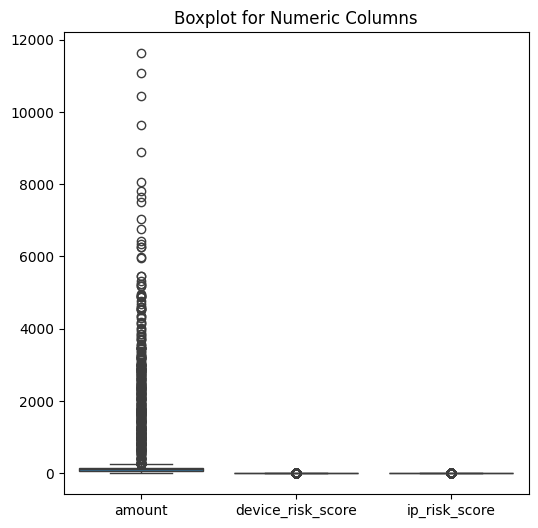

In [35]:
plt.figure(figsize=(6,6))
sns.boxplot(data=df_eda[num_cols])
plt.title("Boxplot for Numeric Columns")
plt.show()

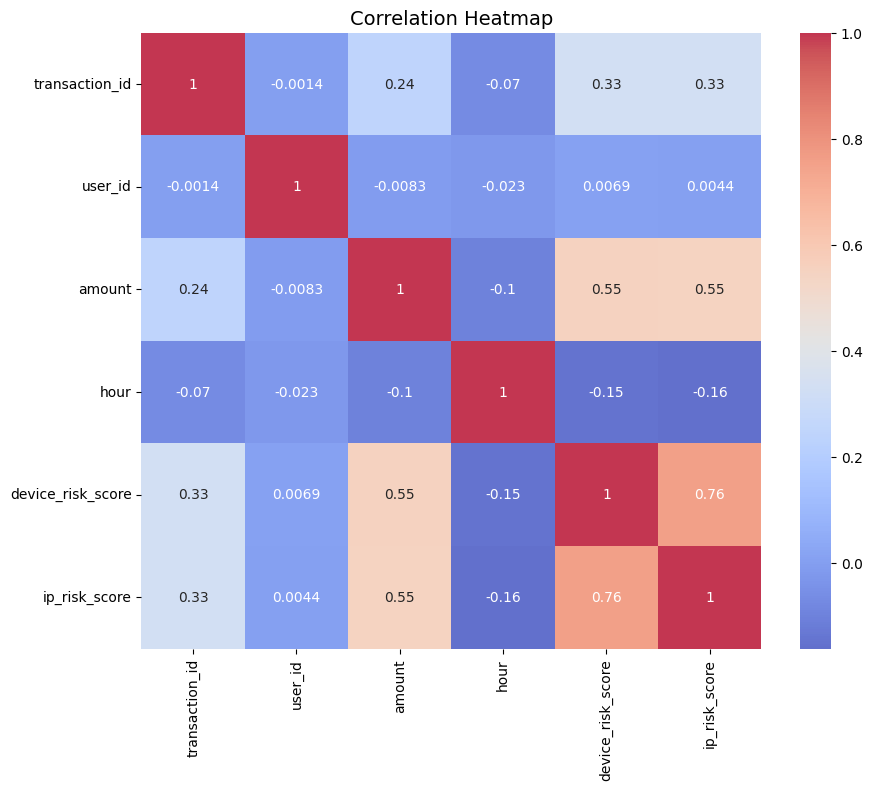

In [36]:
#Heatmap Correlation
num_df=df_eda.select_dtypes(include=np.number)
plt.figure(figsize=(10,8))
sns.heatmap(num_df.corr(), annot=True, cmap='coolwarm', alpha=0.8)
plt.title("Correlation Heatmap",fontsize=14)
plt.show()

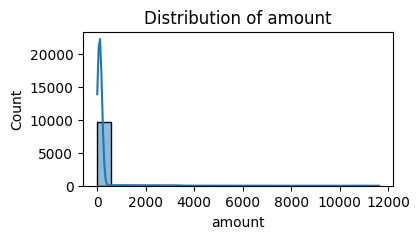

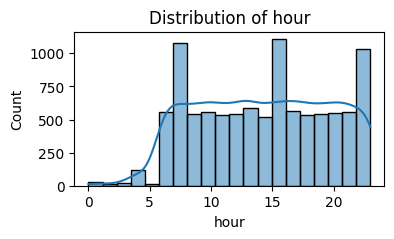

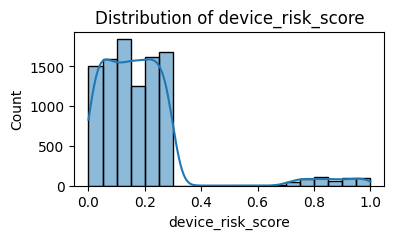

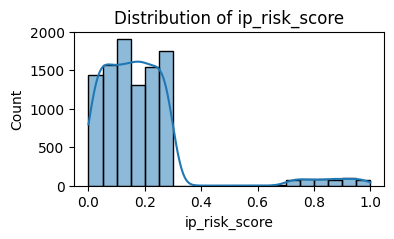

In [37]:
#Histogram Distribution
num_df=df_eda.select_dtypes(include=np.number)
num_df=num_df.drop(columns=['transaction_id','user_id'])

for i in num_df.columns:
    plt.figure(figsize=(4,2))
    sns.histplot(num_df[i], kde=True, bins=20)
    plt.title(f"Distribution of {i}")
plt.show()

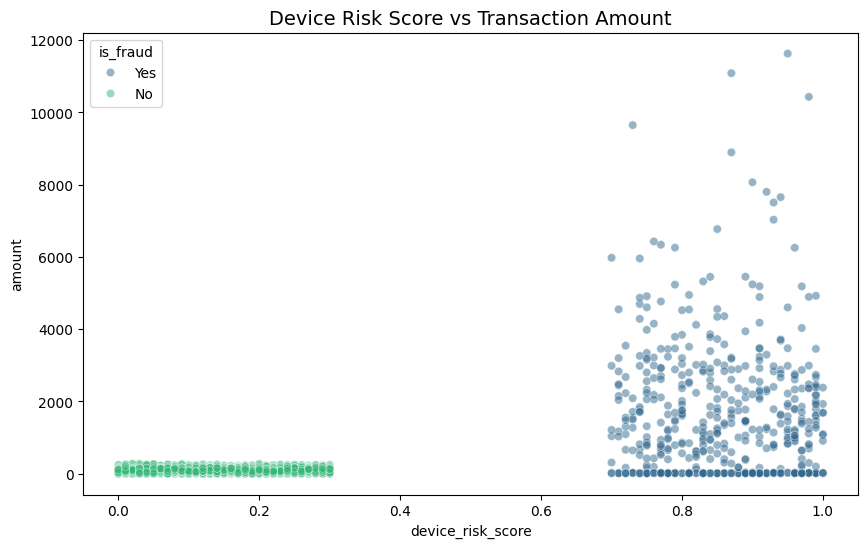

In [41]:
# Device risk score vs transaction amount
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_eda, x='device_risk_score', y='amount', hue='is_fraud', palette='viridis', alpha=0.5)
plt.title("Device Risk Score vs Transaction Amount", fontsize=14)
plt.show()

Overview:
- Small transactions can still be fraudulent when the device risk score is high
- Small transactions are non-fraud only at low device risk scores
- Fraud occurs across both low and high transaction amounts
- High transaction amounts appear only at high device risk scores
- Device risk score is the primary separator between fraud and non-fraud, not transaction amount

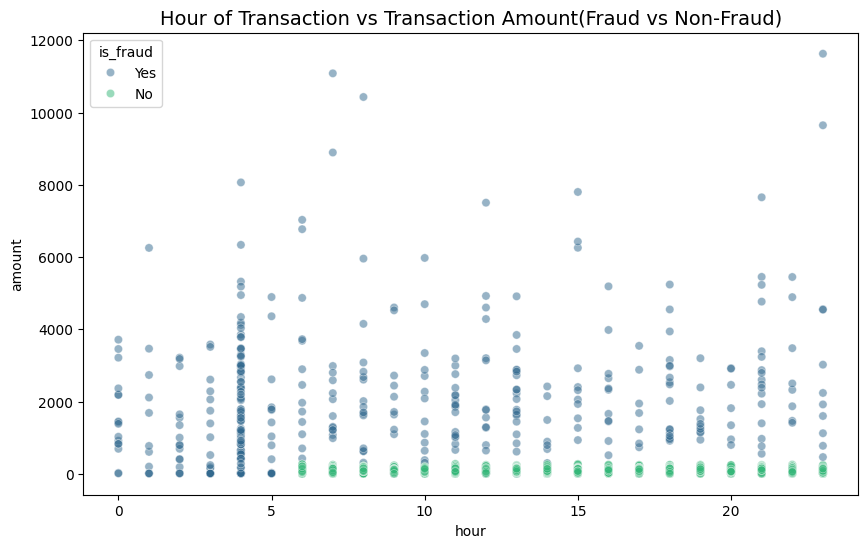

In [42]:
# Hour Transaction vs Fraud coounts
plt.figure(figsize=(10,6))
sns.scatterplot(data =df_eda,x='hour',y='amount', hue='is_fraud',palette='viridis', alpha=0.5)
plt.title("Hour of Transaction vs Transaction Amount(Fraud vs Non-Fraud)", fontsize=14)
plt.show()

Overview:
-Fraud occurs across nearly all hours, with no strong time concentration
-Non-fraud transactions are consistently clustered at low amounts throughout the day
-Fraud appears at both low and high transaction amounts, regardless of hour
-High-value transactions are almost exclusively fraud, across all hours
-No clear time-based pattern distinguishes fraud from non-fraud
-Transaction hour alone is not a strong separator between fraud and non-fraud

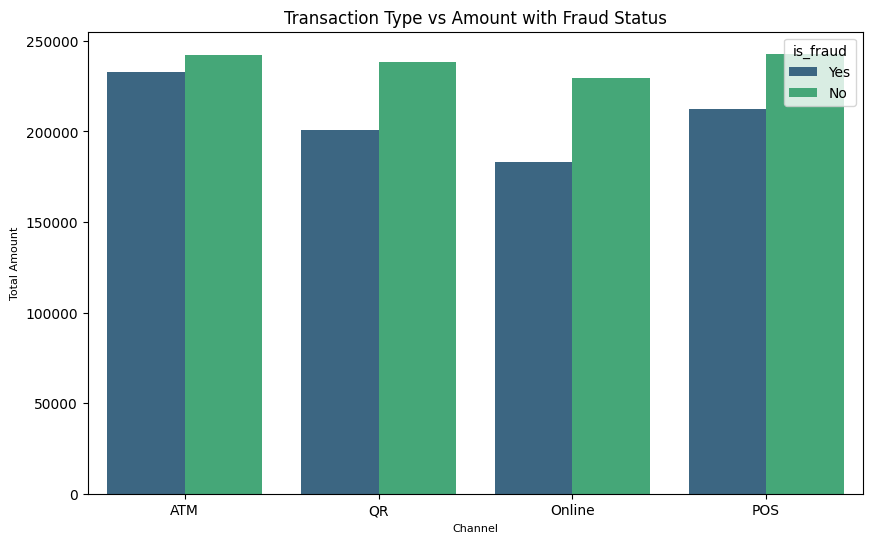

In [160]:
# Transaction Channel vs Amount with Fraud Status
plt.figure(figsize=(10,6))
sns.barplot(data=df_eda,x='transaction_type',y='amount',hue='is_fraud',estimator=np.sum, errorbar=None, palette='viridis')
plt.title("Transaction Type vs Amount with Fraud Status", fontsize=12)
plt.xlabel("Channel", fontsize=8)
plt.ylabel("Total Amount", fontsize=8)

plt.show()

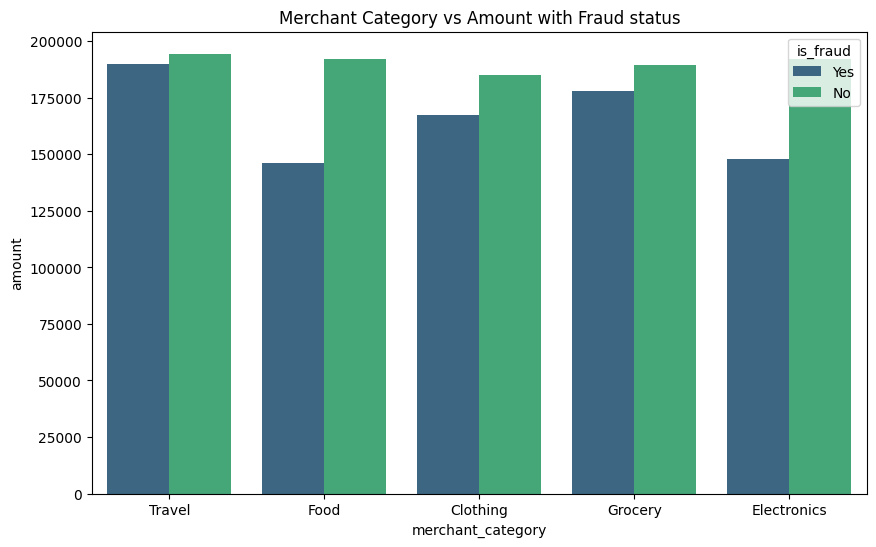

In [161]:
# Merchant Category vs Amount with Fraud Status
plt.figure(figsize=(10,6))
sns.barplot(data=df_eda,x='merchant_category',y='amount',hue='is_fraud', estimator=np.sum,errorbar=None, palette='viridis')
plt.title("Merchant Category vs Amount with Fraud status",fontsize=12)
plt.show()

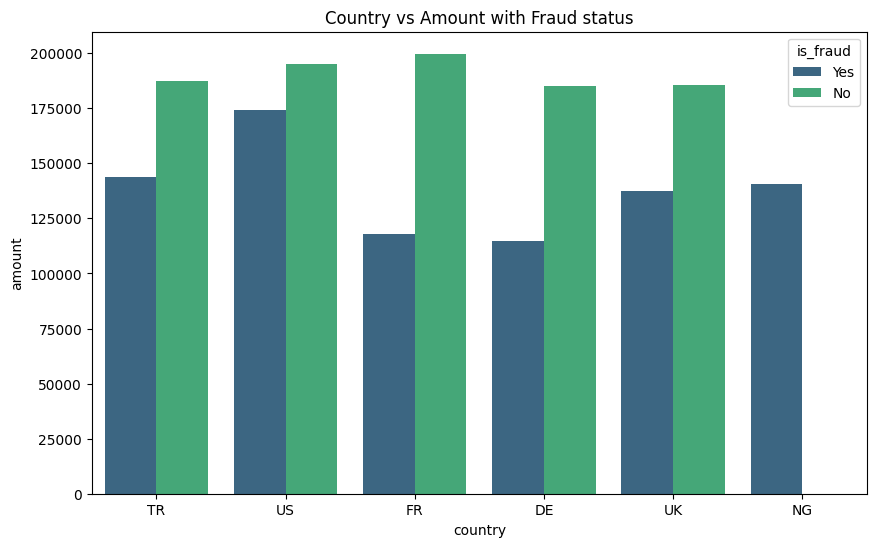

In [162]:
# Country vs Amount with Fraud Status
plt.figure(figsize=(10,6))
sns.barplot(data=df_eda,x='country',y='amount',hue='is_fraud', estimator=np.sum,errorbar=None, palette='viridis')
plt.title("Country vs Amount with Fraud status",fontsize=12)
plt.show()

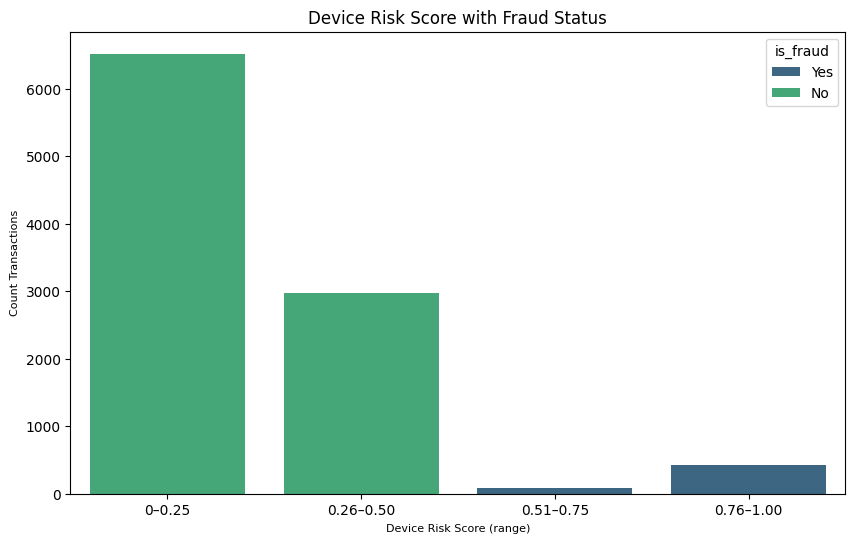

In [168]:
# Device Risk Score with Fraud
bins = [0, 0.2, 0.5, 0.75, 1.0]
labels = ["0–0.25", "0.26–0.50", "0.51–0.75", "0.76–1.00"]

df_eda['range'] = pd.cut(df_eda['device_risk_score'], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(10,6))
sns.countplot(data=df_eda,x=df_eda["range"], hue='is_fraud',palette='viridis')
plt.title("Device Risk Score with Fraud Status", fontsize=12)
plt.xlabel("Device Risk Score (range)", fontsize=8)
plt.ylabel("Count Transactions", fontsize=8)
plt.show()

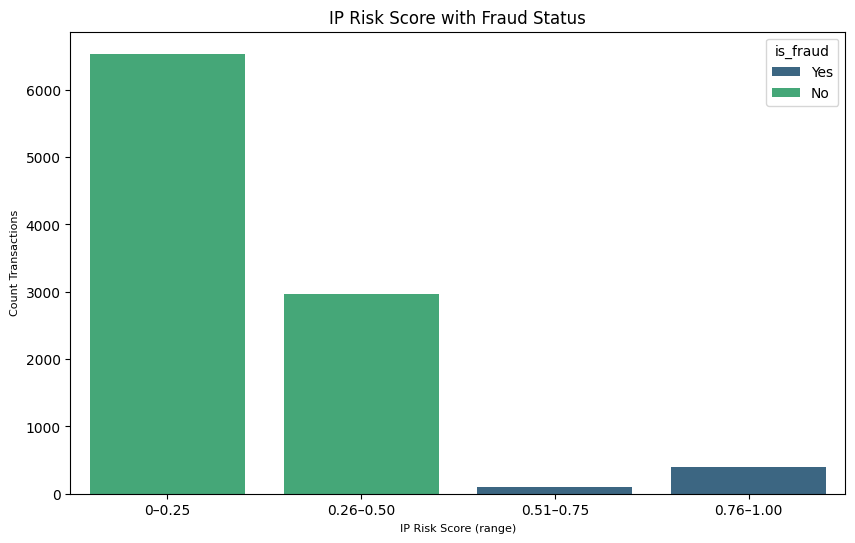

In [170]:
# IP Risk Score with Fraud
bins = [0, 0.2, 0.5, 0.75, 1.0]
labels = ["0–0.25", "0.26–0.50", "0.51–0.75", "0.76–1.00"]

df_eda["range"] = pd.cut(df_eda["ip_risk_score"], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(10,6))
sns.countplot(data=df_eda,x=df_eda["range"], hue='is_fraud',palette='viridis')
plt.title("IP Risk Score with Fraud Status", fontsize=12)
plt.xlabel("IP Risk Score (range)", fontsize=8)
plt.ylabel("Count Transactions", fontsize=8)
plt.show()

## Logistic Regresion Model
Pada tahap ini, penulis mencoba untuk melakukan prediksi modelling menggunakan Logistic Regresion untuk tahap awal mengasah kemampuan dalam data. Data yang digunakan data yang sama dengan proses EDA dan visualisasi tetapi di-load ulang

In [5]:
# Load Data
df_raw=pd.read_csv(r"C:\Postgre_dataset\Financial Fraud Dataset\synthetic_fraud_dataset.csv")

df_raw['is_fraud']=df_raw['is_fraud'].replace({0:'No',1:'Yes'})
df_raw.head(5)



,transaction_id,user_id,amount,transaction_type,merchant_category,country,hour,device_risk_score,ip_risk_score,is_fraud
0,9608,363,4922.587542,ATM,Travel,TR,12,0.992347,0.947908,Yes
1,456,692,48.018303,QR,Food,US,21,0.168571,0.224057,No
2,4747,587,136.881960,Online,Travel,TR,14,0.296127,0.125058,No
3,6934,445,80.534719,POS,Clothing,TR,23,0.124801,0.159243,No
4,1646,729,120.041158,Online,Grocery,FR,16,0.098129,0.027542,No


### Data Preparation

In [6]:
# Data Preparation

df_raw = df_raw.copy() 

# Encode target
df_raw['is_fraud'] = df_raw['is_fraud'].map({'No':0, 'Yes':1})

# Encode categorical features
cat_cols = ['transaction_type', 'merchant_category', 'country']
df_encoded = pd.get_dummies(df_raw, columns=cat_cols, drop_first=True)

# Split X , Y
X = df_encoded.drop(['transaction_id','user_id','is_fraud'], axis=1)
y = df_encoded['is_fraud']


In [180]:
df_encoded.head(5)

,transaction_id,user_id,amount,hour,device_risk_score,ip_risk_score,is_fraud,transaction_type_Online,transaction_type_POS,transaction_type_QR,merchant_category_Electronics,merchant_category_Food,merchant_category_Grocery,merchant_category_Travel,country_FR,country_NG,country_TR,country_UK,country_US
0,9608,363,4922.587542,12,0.992347,0.947908,1,False,False,False,False,False,False,True,False,False,True,False,False
1,456,692,48.018303,21,0.168571,0.224057,0,False,False,True,False,True,False,False,False,False,False,False,True
2,4747,587,136.881960,14,0.296127,0.125058,0,True,False,False,False,False,False,True,False,False,True,False,False
3,6934,445,80.534719,23,0.124801,0.159243,0,False,True,False,False,False,False,False,False,False,True,False,False
4,1646,729,120.041158,16,0.098129,0.027542,0,True,False,False,False,False,True,False,True,False,False,False,False


### Split Data

In [24]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [25]:
#Scaling 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Train and Test

In [26]:
#Train Dataset
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [27]:
# Accuracy Score

y_pred = model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1900
           1       1.00      1.00      1.00       100

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [28]:
# Check abnormal train because result 1.0
print(df_encoded.corr()['is_fraud'].sort_values(ascending=False))


is_fraud                         1.000000
device_risk_score                0.871989
ip_risk_score                    0.870738
amount                           0.638435
country_NG                       0.438086
transaction_id                   0.377492
transaction_type_Online          0.006610
user_id                          0.006165
merchant_category_Travel         0.006005
merchant_category_Electronics   -0.002692
merchant_category_Grocery       -0.004208
transaction_type_QR             -0.005612
country_US                      -0.006251
merchant_category_Food          -0.010451
transaction_type_POS            -0.013023
country_UK                      -0.015300
country_TR                      -0.024890
country_FR                      -0.031216
hour                            -0.181448
Name: is_fraud, dtype: float64


Hasil  menunjukan 1.0 karena ada data overfitting dengan device_risk_score (0.87) dan ip_risk_score (0.87) sehingga train dapat menebak dengan mudah sehingga akurasi 1.0. Solusinya, akan drop column device_risk_score dan ip_risk_score

In [7]:
# Drop Column before Train
cols_to_drop = [
    'device_risk_score',
    'ip_risk_score',
    'transaction_id',
    'user_id'
]

df_clean = df_encoded.drop(columns=cols_to_drop)

In [187]:
df_clean.head()

,amount,hour,is_fraud,transaction_type_Online,transaction_type_POS,transaction_type_QR,merchant_category_Electronics,merchant_category_Food,merchant_category_Grocery,merchant_category_Travel,country_FR,country_NG,country_TR,country_UK,country_US
0,4922.587542,12,1,False,False,False,False,False,False,True,False,False,True,False,False
1,48.018303,21,0,False,False,True,False,True,False,False,False,False,False,False,True
2,136.881960,14,0,True,False,False,False,False,False,True,False,False,True,False,False
3,80.534719,23,0,False,True,False,False,False,False,False,False,False,True,False,False
4,120.041158,16,0,True,False,False,False,False,True,False,True,False,False,False,False


### Re - Train
Dilakukan train test ulang dikarenakan ada kolom data yang overfitting (device_risk_score dan ip_risk_score)

In [8]:
# Train Ulang
X = df_clean.drop('is_fraud', axis=1)
y = df_clean['is_fraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

print("Test accuracy:", model.score(X_test, y_test))
df_clean.head()

Test accuracy: 0.99


,amount,hour,is_fraud,transaction_type_Online,transaction_type_POS,transaction_type_QR,merchant_category_Electronics,merchant_category_Food,merchant_category_Grocery,merchant_category_Travel,country_FR,country_NG,country_TR,country_UK,country_US
0,4922.587542,12,1,False,False,False,False,False,False,True,False,False,True,False,False
1,48.018303,21,0,False,False,True,False,True,False,False,False,False,False,False,True
2,136.881960,14,0,True,False,False,False,False,False,True,False,False,True,False,False
3,80.534719,23,0,False,True,False,False,False,False,False,False,False,True,False,False
4,120.041158,16,0,True,False,False,False,False,True,False,True,False,False,False,False


In [9]:
print(df_clean.corr()['is_fraud'].sort_values(ascending=False))

is_fraud                         1.000000
amount                           0.638435
country_NG                       0.438086
transaction_type_Online          0.006610
merchant_category_Travel         0.006005
merchant_category_Electronics   -0.002692
merchant_category_Grocery       -0.004208
transaction_type_QR             -0.005612
country_US                      -0.006251
merchant_category_Food          -0.010451
transaction_type_POS            -0.013023
country_UK                      -0.015300
country_TR                      -0.024890
country_FR                      -0.031216
hour                            -0.181448
Name: is_fraud, dtype: float64


<Axes: xlabel='is_fraud', ylabel='amount'>

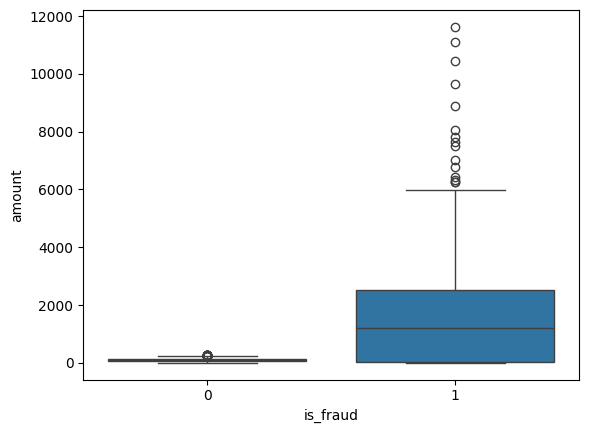

In [10]:
import seaborn as sns
sns.boxplot(x='is_fraud', y='amount', data=df_raw)


### ROC - AUC

In [11]:
#ROC-AUC

# dapatkan probabilitas fraud (kelas 1)
y_proba = model.predict_proba(X_test)[:, 1]

# hitung auc
auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC:", auc)

ROC-AUC: 0.913921052631579


In [12]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1900
           1       1.00      0.80      0.89       100

    accuracy                           0.99      2000
   macro avg       0.99      0.90      0.94      2000
weighted avg       0.99      0.99      0.99      2000



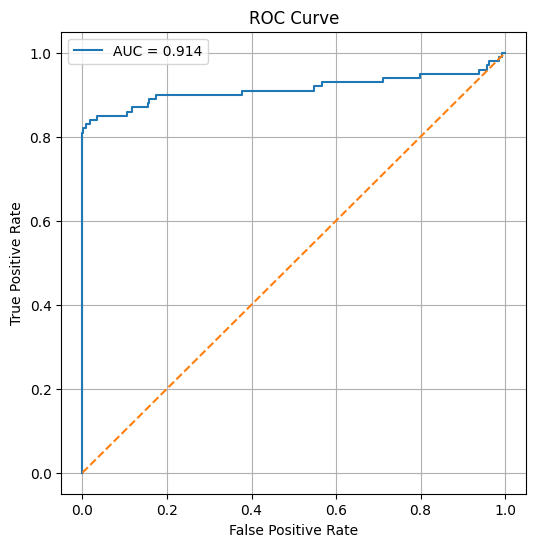

In [13]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0,1], [0,1], linestyle='--')   # garis acak
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

### Implement Model

In [16]:
# Implement Fraud Prob and Fraud Flag -- Result Logistic Regresion

cols_to_drop = []
for c in ['is_fraud','transaction_id','user_id']:
    if c in df_clean.columns:
        cols_to_drop.append(c)

X = df_clean.drop(columns=cols_to_drop)
feature_cols = X.columns.tolist()

print("Jumlah fitur:", len(feature_cols))
print(feature_cols)


# lakukan encoding pada data baru
df_enc = pd.get_dummies(df_raw)
df_enc = df_enc.reindex(columns=feature_cols, fill_value=0)

Jumlah fitur: 14
['amount', 'hour', 'transaction_type_Online', 'transaction_type_POS', 'transaction_type_QR', 'merchant_category_Electronics', 'merchant_category_Food', 'merchant_category_Grocery', 'merchant_category_Travel', 'country_FR', 'country_NG', 'country_TR', 'country_UK', 'country_US']


In [17]:
df_raw['fraud_prob'] = model.predict_proba(df_enc)[:, 1]
df_raw['fraud_flag'] = (df_raw['fraud_prob'] >= 0.5).astype(int)
df_raw.head(5)

,transaction_id,user_id,amount,transaction_type,merchant_category,country,hour,device_risk_score,ip_risk_score,is_fraud,fraud_prob,fraud_flag
0,9608,363,4922.587542,ATM,Travel,TR,12,0.992347,0.947908,1,1.000000,1
1,456,692,48.018303,QR,Food,US,21,0.168571,0.224057,0,0.001131,0
2,4747,587,136.881960,Online,Travel,TR,14,0.296127,0.125058,0,0.011590,0
3,6934,445,80.534719,POS,Clothing,TR,23,0.124801,0.159243,0,0.001566,0
4,1646,729,120.041158,Online,Grocery,FR,16,0.098129,0.027542,0,0.006019,0


Hasil akhir dari analisa modelling Logistic Regresion ini didapat nilai,
ROC–AUC Score: 0.9139
Nilai ini menunjukkan bahwa model memiliki kemampuan yang sangat baik dalam membedakan transaksi fraud dan non-fraud.


Penambahan Kolom Output Model
Setelah model dilatih dan dievaluasi, hasil prediksi kemudian diterapkan ke setiap transaksi dalam dataset.
Ditambahkan 2 kolom baru:
1. fraud_prob
- probabilitas bahwa transaksi tersebut terindikasi fraud
- diperoleh dari model.predict_proba(X)[:,1]
- bernilai 0.0 – 1.0

2.fraud_flag
- hasil flagging berbasis threshold 0.5
- [1] = transaksi berisiko fraud
- [0] = transaksi normal
- diperoleh dari (fraud_prob >= 0.5).astype(int)
Artinya setiap transaksi sekarang punya skor risiko dan label fraud.

## Random Forest

### Data Preparation

In [18]:
# Load Data
df_rf=pd.read_csv(r"C:\Postgre_dataset\Financial Fraud Dataset\synthetic_fraud_dataset.csv")

df_rf['is_fraud']=df_rf['is_fraud'].replace({0:'No',1:'Yes'})
df_rf.head(5)

,transaction_id,user_id,amount,transaction_type,merchant_category,country,hour,device_risk_score,ip_risk_score,is_fraud
0,9608,363,4922.587542,ATM,Travel,TR,12,0.992347,0.947908,Yes
1,456,692,48.018303,QR,Food,US,21,0.168571,0.224057,No
2,4747,587,136.881960,Online,Travel,TR,14,0.296127,0.125058,No
3,6934,445,80.534719,POS,Clothing,TR,23,0.124801,0.159243,No
4,1646,729,120.041158,Online,Grocery,FR,16,0.098129,0.027542,No


In [34]:
# encoded category cols
df_rf=df_rf.copy()

df_rf['is_fraud'] = df_rf['is_fraud'].map({'No':0,'Yes':1})
cat_cols =['merchant_category','country','transaction_type']
df_encoded = pd.get_dummies(df_rf, columns=cat_cols, drop_first=True)

# Split X , Y
X = df_encoded.drop(['transaction_id','user_id','is_fraud','device_risk_score','ip_risk_score'], axis=1)
y = df_encoded['is_fraud']

df_encoded.head(5)


,transaction_id,user_id,amount,hour,device_risk_score,ip_risk_score,is_fraud,merchant_category_Electronics,merchant_category_Food,merchant_category_Grocery,merchant_category_Travel,country_FR,country_NG,country_TR,country_UK,country_US,transaction_type_Online,transaction_type_POS,transaction_type_QR
0,9608,363,4922.587542,12,0.992347,0.947908,1,False,False,False,True,False,False,True,False,False,False,False,False
1,456,692,48.018303,21,0.168571,0.224057,0,False,True,False,False,False,False,False,False,True,False,False,True
2,4747,587,136.881960,14,0.296127,0.125058,0,False,False,False,True,False,False,True,False,False,True,False,False
3,6934,445,80.534719,23,0.124801,0.159243,0,False,False,False,False,False,False,True,False,False,False,True,False
4,1646,729,120.041158,16,0.098129,0.027542,0,False,False,True,False,True,False,False,False,False,True,False,False


### Split Data

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

### Train and Test

In [20]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

model_rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [37]:
model_rf.score(X_test, y_test)

0.995

### ROC - AUC

In [21]:
y_pred_prob = model_rf.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred_prob)
print("roc_auc_score:",auc)

roc_auc_score: 0.9939342105263158


In [22]:
from sklearn.metrics import classification_report

y_pred = model_rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1900
           1       1.00      0.89      0.94       100

    accuracy                           0.99      2000
   macro avg       1.00      0.95      0.97      2000
weighted avg       0.99      0.99      0.99      2000



In [40]:
import numpy as np

importance = model_rf.feature_importances_
feat_imp = pd.DataFrame({
    'feature': X.columns,
    'importance': importance
}).sort_values(by='importance', ascending=False)

feat_imp.head(20)

,feature,importance
0,amount,0.673081
1,hour,0.200370
7,country_NG,0.070422
13,transaction_type_QR,0.005872
6,country_FR,0.005797
11,transaction_type_Online,0.005668
8,country_TR,0.005660
10,country_US,0.005581
4,merchant_category_Grocery,0.004938
2,merchant_category_Electronics,0.004863


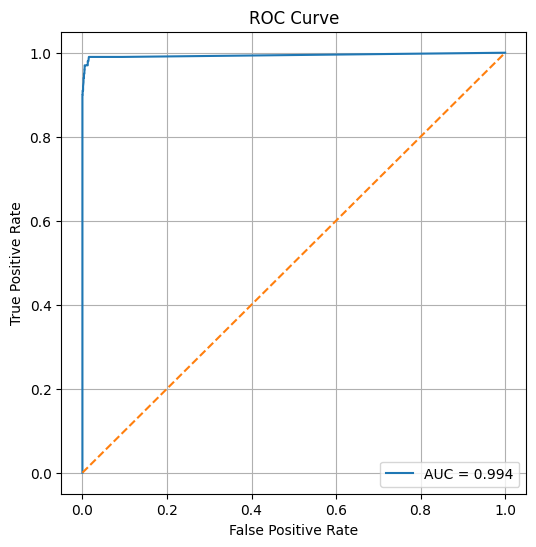

In [43]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0,1], [0,1], linestyle='--')   # garis acak
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

Dari hasil model Random Forest didapatkan nilau AUC 0.994 lebih baik dibandingkan dengan model Logistic Regresion (AUC 0.914)

### Implement Model

In [51]:
df_new_enc = pd.get_dummies(df_rf)
df_new_enc = df_new_enc.reindex(columns=X.columns, fill_value=0)
df_rf['fraud_prob'] = model_rf.predict_proba(df_new_enc)[:,1]
df_rf['fraud_flag'] = (df_rf['fraud_prob'] >= 0.5).astype(int)

df_rf=df_rf.sort_values(by= 'is_fraud', ascending=False)
df_rf.head()

,transaction_id,user_id,amount,transaction_type,merchant_category,country,hour,device_risk_score,ip_risk_score,is_fraud,fraud_prob,fraud_flag
9144,9610,647,10.000000,POS,Electronics,FR,5,0.832040,0.951143,1,0.98,1
9185,9975,554,10.000000,ATM,Food,UK,13,0.738264,0.867665,1,0.86,1
2245,9706,528,913.231918,ATM,Grocery,UK,18,0.963203,0.768485,1,0.92,1
9217,9875,545,10.000000,Online,Clothing,NG,17,0.812426,0.866400,1,0.99,1
4818,9789,444,2101.956898,POS,Travel,TR,4,0.888291,0.998384,1,1.00,1


Hasil akhir dari analisa modelling Random Forest ini didapat nilai,
ROC–AUC Score: 0.994
Nilai ini menunjukkan bahwa model memiliki kemampuan yang sangat baik dalam membedakan transaksi fraud dan non-fraud dan mendapatkan nilai ROC - AUC lebih baik dibandingkan model Logistic Regresion

## XGBoost

### Data Preparation

In [20]:
# Load Data
df_xg=pd.read_csv(r"C:\Postgre_dataset\Financial Fraud Dataset\synthetic_fraud_dataset.csv")

df_xg['is_fraud']=df_xg['is_fraud'].replace({0:'No',1:'Yes'})
df_xg.head(5)

,transaction_id,user_id,amount,transaction_type,merchant_category,country,hour,device_risk_score,ip_risk_score,is_fraud
0,9608,363,4922.587542,ATM,Travel,TR,12,0.992347,0.947908,Yes
1,456,692,48.018303,QR,Food,US,21,0.168571,0.224057,No
2,4747,587,136.881960,Online,Travel,TR,14,0.296127,0.125058,No
3,6934,445,80.534719,POS,Clothing,TR,23,0.124801,0.159243,No
4,1646,729,120.041158,Online,Grocery,FR,16,0.098129,0.027542,No


In [21]:
# encoded category cols
df_xg=df_xg.copy()

df_xg['is_fraud'] = df_xg['is_fraud'].map({'No':0,'Yes':1})
cat_cols =['merchant_category','country','transaction_type']
df_encoded = pd.get_dummies(df_xg, columns=cat_cols, drop_first=True)

# Split X , Y
X = df_encoded.drop(['transaction_id','user_id','is_fraud','device_risk_score','ip_risk_score'], axis=1)
y = df_encoded['is_fraud']

df_encoded.head(5)


,transaction_id,user_id,amount,hour,device_risk_score,ip_risk_score,is_fraud,merchant_category_Electronics,merchant_category_Food,merchant_category_Grocery,merchant_category_Travel,country_FR,country_NG,country_TR,country_UK,country_US,transaction_type_Online,transaction_type_POS,transaction_type_QR
0,9608,363,4922.587542,12,0.992347,0.947908,1,False,False,False,True,False,False,True,False,False,False,False,False
1,456,692,48.018303,21,0.168571,0.224057,0,False,True,False,False,False,False,False,False,True,False,False,True
2,4747,587,136.881960,14,0.296127,0.125058,0,False,False,False,True,False,False,True,False,False,True,False,False
3,6934,445,80.534719,23,0.124801,0.159243,0,False,False,False,False,False,False,True,False,False,False,True,False
4,1646,729,120.041158,16,0.098129,0.027542,0,False,False,True,False,True,False,False,False,False,True,False,False


### Split Data

In [22]:
# Split Data
X_train, X_full_test, y_train, y_full_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y
)
X_valid,X_test, y_valid, y_test = train_test_split(X_full_test, y_full_test, test_size=0.5, random_state=42, stratify=y_full_test)

print(len(X_train), len(X_valid), len(X_test))
X_train.head(5)

6000 2000 2000


,amount,hour,merchant_category_Electronics,merchant_category_Food,merchant_category_Grocery,merchant_category_Travel,country_FR,country_NG,country_TR,country_UK,country_US,transaction_type_Online,transaction_type_POS,transaction_type_QR
6500,129.134348,18,False,False,False,False,False,False,False,False,True,True,False,False
9426,1.000000,6,False,False,True,False,False,False,False,False,False,False,False,True
8947,75.250490,15,False,False,False,False,False,False,False,False,True,False,False,True
7166,114.025001,11,False,False,False,False,False,False,False,False,False,True,False,False
6913,71.804177,8,False,False,True,False,False,False,False,True,False,False,True,False


### Train and Test

In [18]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,          # number of trees
    max_depth=6,              # depth of each tree
    learning_rate=0.05,       # step size
    subsample=0.8,            # row sampling
    colsample_bytree=0.8,     # feature sampling
    objective='binary:logistic',
    eval_metric='auc',        # VALID for your version
    random_state=42,
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train)
)

# Train with validation monitoring
xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=True
)

[0]	validation_0-auc:0.99917	validation_1-auc:0.98822
[1]	validation_0-auc:0.99920	validation_1-auc:0.98822
[2]	validation_0-auc:0.99912	validation_1-auc:0.98648
[3]	validation_0-auc:0.99912	validation_1-auc:0.98897
[4]	validation_0-auc:0.99929	validation_1-auc:0.98909
[5]	validation_0-auc:0.99922	validation_1-auc:0.99067
[6]	validation_0-auc:0.99931	validation_1-auc:0.99075
[7]	validation_0-auc:0.99936	validation_1-auc:0.99077
[8]	validation_0-auc:0.99936	validation_1-auc:0.98804
[9]	validation_0-auc:0.99942	validation_1-auc:0.98810
[10]	validation_0-auc:0.99948	validation_1-auc:0.98813
[11]	validation_0-auc:0.99953	validation_1-auc:0.98791
[12]	validation_0-auc:0.99956	validation_1-auc:0.98855
[13]	validation_0-auc:0.99960	validation_1-auc:0.98855
[14]	validation_0-auc:0.99963	validation_1-auc:0.98948
[15]	validation_0-auc:0.99962	validation_1-auc:0.98970
[16]	validation_0-auc:0.99965	validation_1-auc:0.98971
[17]	validation_0-auc:0.99966	validation_1-auc:0.98978
[18]	validation_0-au

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


### ROC - AUC

In [47]:
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
y_pred = xgb_model.predict(X_test)

print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

ROC-AUC: 0.9997894736842106
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1900
           1       0.94      0.99      0.97       100

    accuracy                           1.00      2000
   macro avg       0.97      0.99      0.98      2000
weighted avg       1.00      1.00      1.00      2000

[[1894    6]
 [   1   99]]


In [48]:
import numpy as np

importance = xgb_model.feature_importances_
feat_imp = pd.DataFrame({
    'feature': X.columns,
    'importance': importance
}).sort_values(by='importance', ascending=False)

feat_imp.head(20)

,feature,importance
0,amount,0.584028
7,country_NG,0.190379
1,hour,0.076968
13,transaction_type_QR,0.018707
3,merchant_category_Food,0.017363
6,country_FR,0.017229
5,merchant_category_Travel,0.015663
10,country_US,0.014400
12,transaction_type_POS,0.014127
4,merchant_category_Grocery,0.013607


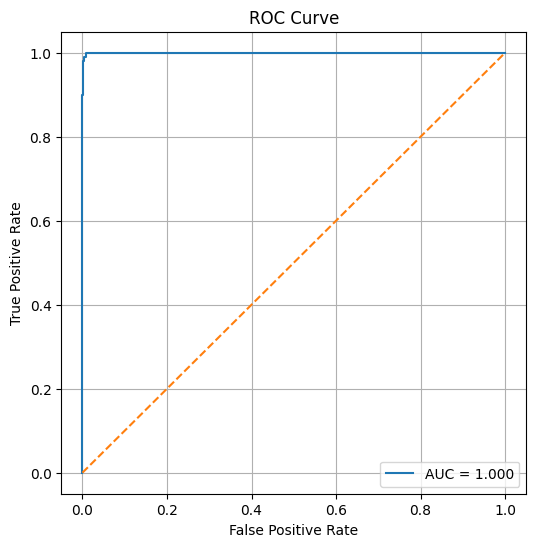

In [49]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0,1], [0,1], linestyle='--')   # garis acak
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

Dari hasil model XGBoost didapatkan nilau AUC 0.997 (~1.000) lebih baik dibandingkan dengan model Random Forest (AUC 0.994)

### Implement Model

In [46]:
df_new_enc = pd.get_dummies(df_xg)
df_new_enc = df_new_enc.reindex(columns=X.columns, fill_value=0)
df_xg['fraud_prob'] = xgb_model.predict_proba(df_new_enc)[:,1]
df_xg['fraud_flag'] = (df_xg['fraud_prob'] >= 0.5).astype(int)

df_xg=df_xg.sort_values(by= 'is_fraud', ascending=False)

df_xg.head()

,transaction_id,user_id,amount,transaction_type,merchant_category,country,hour,device_risk_score,ip_risk_score,is_fraud,fraud_prob,fraud_flag
3685,9516,260,3391.206967,ATM,Electronics,NG,21,0.835788,0.728362,1,0.999961,1
9247,9846,296,3010.668220,ATM,Clothing,US,4,0.824202,0.978674,1,0.999972,1
2378,9951,336,4555.012754,QR,Grocery,DE,23,0.849233,0.829839,1,0.999447,1
9253,9705,330,1944.100766,Online,Travel,NG,17,0.881831,0.769744,1,0.999956,1
4174,9766,159,22.168429,ATM,Clothing,UK,11,0.725096,0.785528,1,0.981570,1


Hasil akhir dari analisa modelling XGBoost ini didapat nilai,
ROC–AUC Score: 0.99978
Nilai ini menunjukkan bahwa model memiliki kemampuan yang sangat baik dalam membedakan transaksi fraud dan non-fraud dan mendapatkan nilai ROC - AUC lebih baik dibandingkan model Logistic Regresion dan Random Forest